In [1]:
import math
import random

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import numpy.random as nprand
import pandas as pd
import plotly.graph_objects as go
import plotly.express as pex
import repsci
import scipy.stats as spstats

from loomio import *
from socialchoice import *
from netdelib import *

%matplotlib inline

matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['lines.markersize'] = 9

In [2]:
exp = repsci.Experiment('flow')

In [3]:
df_score, proposal_map, proposal_rev_map = load_loomio_score('results/results_2_3.tsv')
df_score = fill_attrition(df_score, min_stages=2)

treatments = {
    1: "Single Group",
    2: "Random Pod",
}

df_control = df_score[df_score.treatment == 1]
df_random = df_score[df_score.treatment == 2]

In [4]:
control_preferences = make_preference_sequence_collection(df_control)
random_preferences = make_preference_sequence_collection(df_random)

In [5]:
def get_counts(preferences):
    alternatives = ['prop1', 'prop2', 'prop3', 'prop4', 'prop5', 'prop6']

    stages = range(4)
    counts = dict([(alt, [0]*4) for alt in alternatives])

    for part, seq in preferences.items():
        for stage in stages:
            alt = seq[stage].first_place()
            counts[alt][stage] += 1

    return counts

In [6]:
alternatives = ['prop1', 'prop2', 'prop3', 'prop4', 'prop5', 'prop6']
stages = range(4)

def plot_counts(counts):
    bar_width = 0.8

    colors = [
        '#848',
        '#b6b',
        '#488',
        '#6bb',
        '#884',
        '#bb6',
    ]

    y_offset = np.zeros(4)
    for i, alt in enumerate(alternatives):
        plt.bar(stages, counts[alt], bar_width, bottom=y_offset, color=colors[i])
        y_offset = y_offset + counts[alt]


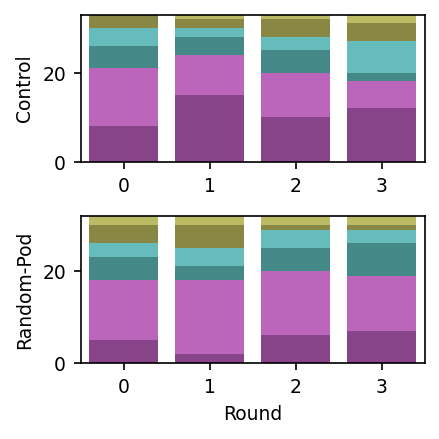

In [7]:

plt.figure(figsize=(3,3))

ax = plt.subplot(2,1,1)
plot_counts(get_counts(control_preferences))
plt.ylim([0,len(control_preferences)])
plt.ylabel('Control')
plt.xlim([-.5,3.5])
plt.xticks(range(4), labels=range(4))
plt.grid(which='minor', axis='y', linewidth=1)
ax.set_axisbelow(True)

plt.subplot(2,1,2)
plot_counts(get_counts(random_preferences))
plt.ylim([0,len(random_preferences)])
plt.ylabel('Random-Pod')
plt.xlabel('Round')
plt.xlim([-.5,3.5])
plt.xticks(range(4), labels=range(4))

plt.tight_layout()
plt.savefig(exp.get_filename('fig-counts.eps'))
plt.savefig(exp.get_filename('fig-counts.png'), dpi=600)

In [8]:
get_counts(control_preferences)

{'prop1': [8, 15, 10, 12],
 'prop2': [13, 9, 10, 6],
 'prop3': [5, 4, 5, 2],
 'prop4': [4, 2, 3, 7],
 'prop5': [3, 2, 4, 4],
 'prop6': [0, 1, 1, 2]}

In [9]:
get_counts(random_preferences)

{'prop1': [5, 2, 6, 7],
 'prop2': [13, 16, 14, 12],
 'prop3': [5, 3, 5, 7],
 'prop4': [3, 4, 4, 3],
 'prop5': [4, 5, 1, 1],
 'prop6': [2, 2, 2, 2]}

In [10]:
def get_transition_matrix(preferences, stage_i=0, stage_f=3):
    alternatives = ['prop1', 'prop2', 'prop3', 'prop4', 'prop5', 'prop6']
    alt_map = dict((alt, i) for i, alt in enumerate(alternatives))

    result = np.zeros(shape=(6,6))
    
    for part, seq in preferences.items():
        alt_from = seq[stage_i].first_place()
        alt_to = seq[stage_f].first_place()
        result[alt_map[alt_from], alt_map[alt_to]] += 1

    return result

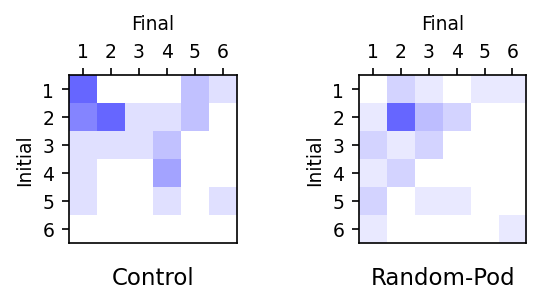

In [11]:
cdict = {
    'red': [[0.0, 1.0, 1.0],
            [1.0, 0.4, 0.4]],
    'green': [[0.0, 1.0, 1.0],
              [1.0, 0.4, 0.4]],
    'blue': [[0.0, 1.0, 1.0],
             [1.0, 1.0, 1.0]]
}
flow_map = LinearSegmentedColormap('flow', cdict)

control_im = get_transition_matrix(control_preferences)
random_im = get_transition_matrix(random_preferences)

plt.figure(figsize=(4,2))

ax = plt.subplot(1,2,1)
plt.imshow(control_im, cmap=flow_map)
ax.tick_params(labelbottom=False, labeltop=True)
ax.xaxis.tick_top()
plt.xticks(range(6), labels=range(1,7))
plt.yticks(range(6), labels=range(1,7))
plt.ylabel('Initial')
plt.xlabel('Control', fontsize=11, labelpad=11)
plt.title('Final', fontsize=9)

ax = plt.subplot(1,2,2)
ax.tick_params(labelbottom=False, labeltop=True)
ax.xaxis.tick_top()
plt.imshow(random_im, cmap=flow_map)
plt.xticks(range(6), labels=range(1,7))
plt.yticks(range(6), labels=range(1,7))
plt.ylabel('Initial')
plt.xlabel('Random-Pod', fontsize=11, labelpad=11)
plt.title('Final', fontsize=9)

plt.tight_layout()
plt.savefig(exp.get_filename('fig-count-matrix.eps'))
plt.savefig(exp.get_filename('fig-count-matrix.png'), dpi=600)

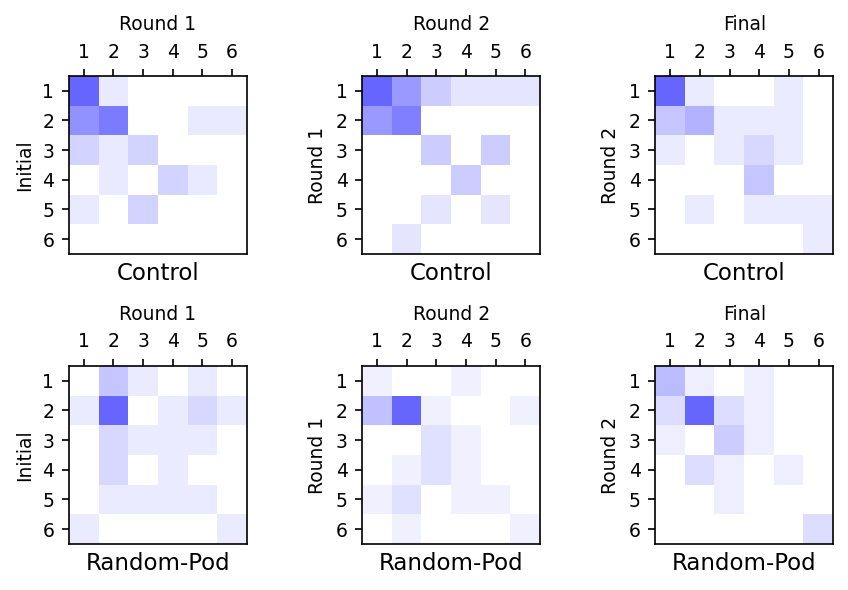

In [12]:
flow_map = LinearSegmentedColormap('flow', cdict)

plt.figure(figsize=(6,4))

for stage in range(3):
    si = stage
    sf = stage + 1
    control_im = get_transition_matrix(control_preferences, stage_i=si, stage_f=sf)
    random_im = get_transition_matrix(random_preferences, stage_i=si, stage_f=sf)

    ax = plt.subplot(2,3,1+stage)
    plt.imshow(control_im, cmap=flow_map)
    ax.tick_params(labelbottom=False, labeltop=True)
    ax.xaxis.tick_top()
    plt.xticks(range(6), labels=range(1,7))
    plt.yticks(range(6), labels=range(1,7))
    if stage == 0:
        plt.ylabel('Initial')
    else:
        plt.ylabel('Round {}'.format(stage))
    plt.xlabel('Control', fontsize=11)
    if stage == 2:
        plt.title('Final', fontsize=9)
    else:
        plt.title('Round {}'.format(stage+1), fontsize=9)

    ax = plt.subplot(2,3,4+stage)
    ax.tick_params(labelbottom=False, labeltop=True)
    ax.xaxis.tick_top()
    plt.imshow(random_im, cmap=flow_map)
    plt.xticks(range(6), labels=range(1,7))
    plt.yticks(range(6), labels=range(1,7))
    if stage == 0:
        plt.ylabel('Initial')
    else:
        plt.ylabel('Round {}'.format(stage))
    plt.xlabel('Random-Pod', fontsize=11)
    if stage == 2:
        plt.title('Final', fontsize=9)
    else:
        plt.title('Round {}'.format(stage+1), fontsize=9)

plt.tight_layout()
plt.savefig(exp.get_filename('fig-round-matrix.eps'))
plt.savefig(exp.get_filename('fig-round-matrix.png'), dpi=600)

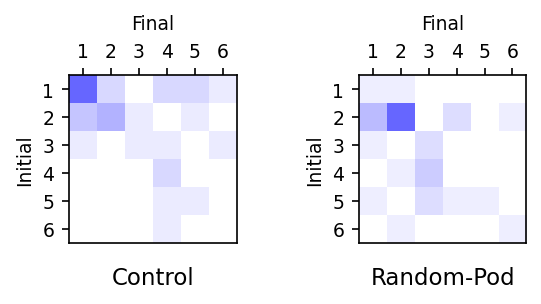

In [13]:
cdict = {
    'red': [[0.0, 1.0, 1.0],
            [1.0, 0.4, 0.4]],
    'green': [[0.0, 1.0, 1.0],
              [1.0, 0.4, 0.4]],
    'blue': [[0.0, 1.0, 1.0],
             [1.0, 1.0, 1.0]]
}
flow_map = LinearSegmentedColormap('flow', cdict)

control_im = get_transition_matrix(control_preferences, stage_i=1, stage_f=3)
random_im = get_transition_matrix(random_preferences, stage_i=1, stage_f=3)

plt.figure(figsize=(4,2))

ax = plt.subplot(1,2,1)
plt.imshow(control_im, cmap=flow_map)
ax.tick_params(labelbottom=False, labeltop=True)
ax.xaxis.tick_top()
plt.xticks(range(6), labels=range(1,7))
plt.yticks(range(6), labels=range(1,7))
plt.ylabel('Initial')
plt.xlabel('Control', fontsize=11, labelpad=11)
plt.title('Final', fontsize=9)

ax = plt.subplot(1,2,2)
ax.tick_params(labelbottom=False, labeltop=True)
ax.xaxis.tick_top()
plt.imshow(random_im, cmap=flow_map)
plt.xticks(range(6), labels=range(1,7))
plt.yticks(range(6), labels=range(1,7))
plt.ylabel('Initial')
plt.xlabel('Random-Pod', fontsize=11, labelpad=11)
plt.title('Final', fontsize=9)

plt.tight_layout()

In [14]:
changed = []
for part, seq in control_preferences.items():
    if seq[0].first_place() == 'prop1':
        changed.append(part)
        print(part)
        print(seq.display())

8
	prop1	prop2	prop3	prop4	prop5	prop6
	prop1	prop2	prop3	prop4	prop5	prop6
	prop1	prop2	prop3	prop4	prop5	prop6
	prop1	prop2	prop4	prop3	prop5	prop6

17
	prop1	prop6	prop5	prop3	prop4	prop2
	prop1	prop5	prop6	prop3	prop4	prop2
	prop1	prop5	prop6	prop3	prop4	prop2
	prop1	prop5	prop6	prop3	prop4	prop2

19
	prop1	prop3	prop2	prop5	prop4	prop6
	prop1	prop2	prop5	prop3	prop4	prop6
	prop1	prop5	prop3	prop2	prop4	prop6
	prop1	prop5	prop3	prop2	prop4	prop6

32
	prop1	prop2	prop4	prop3	prop5	prop6
	prop2	prop1	prop4	prop3	prop6	prop5
	prop1	prop2	prop3	prop4	prop6	prop5
	prop1	prop2	prop3	prop4	prop6	prop5

33
	prop1	prop2	prop4	prop3	prop6	prop5
	prop1	prop2	prop4	prop3	prop5	prop6
	prop1	prop2	prop3	prop4	prop6	prop5
	prop1	prop2	prop4	prop3	prop6	prop5

57
	prop1	prop3	prop5	prop4	prop6	prop2
	prop1	prop3	prop6	prop2	prop5	prop4
	prop3	prop5	prop1	prop4	prop6	prop2
	prop5	prop3	prop1	prop2	prop4	prop6

58
	prop1	prop2	prop6	prop4	prop5	prop3
	prop1	prop4	prop6	prop2	prop5	prop3
	prop2	prop6

In [20]:
print(control_preferences[7].display())

	prop3	prop5	prop4	prop1	prop2	prop6
	prop1	prop2	prop3	prop4	prop5	prop6
	prop3	prop2	prop1	prop6	prop5	prop4
	prop4	prop3	prop2	prop1	prop6	prop5

